In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install Libraries
!pip install biopython
!pip install MDAnalysis

In [ ]:
#import necessary libraries

from Bio.PDB import PDBParser, PDBIO, Select, PPBuilder, is_aa
from scipy.spatial.distance import pdist, squareform
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define a selection class to filter only standard amino acid residues
class ProteinChainSelect(Select):
    def accept_residue(self, residue):
        # Accept only standard amino acids (skipping waters, ligands, etc.)
        return residue.id[0] == ' '

# Specify the input file path (unrelaxed model) and the output path
input_pdb = "/content/drive/MyDrive/Protein_str/PHF20_prediction_c7251_relaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb"
output_pdb = "/content/drive/MyDrive/Protein_str/PHF20_prediction_cleaned.pdb"

# Parse the PDB file
parser = PDBParser(QUIET=True)
structure = parser.get_structure("PHF20", input_pdb)

# Select the first model (if multiple models exist)
model = structure[0]

# Save the cleaned structure
io = PDBIO()
io.set_structure(model)
io.save(output_pdb, ProteinChainSelect())

print(f"Cleaned PDB saved as {output_pdb}")

Cleaned PDB saved as /content/drive/MyDrive/Protein_str/PHF20_prediction_cleaned.pdb


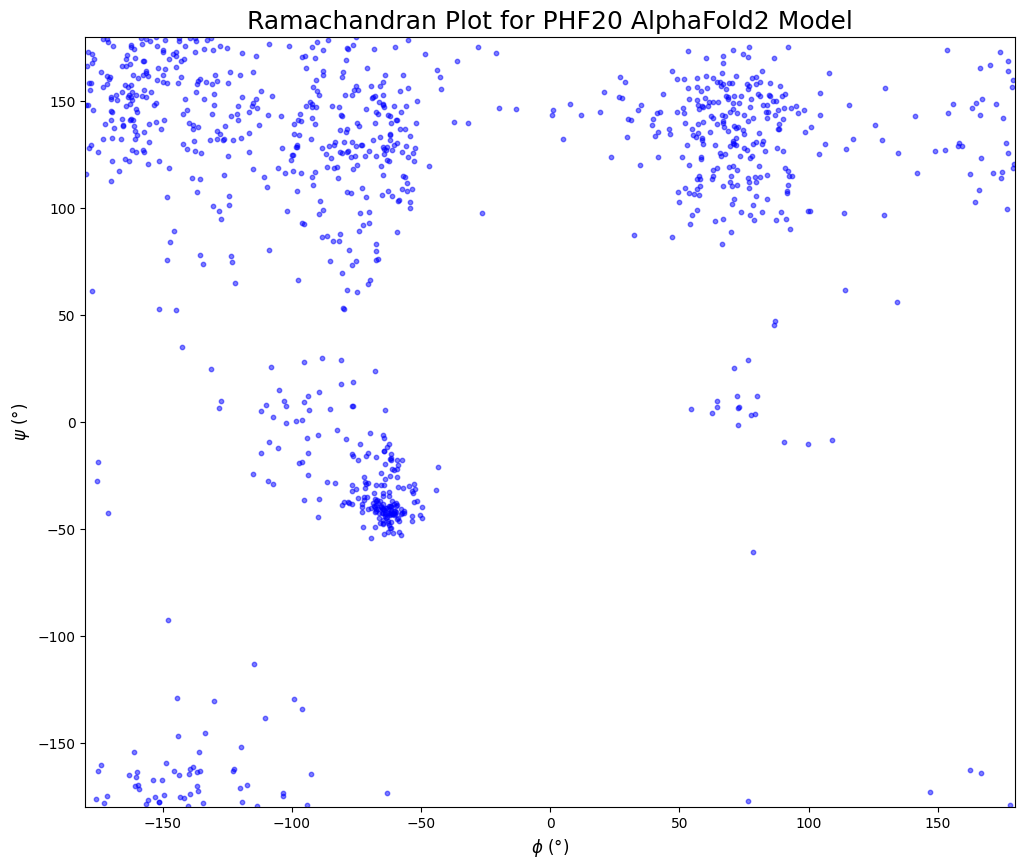

Ramachandran plot saved to /content/drive/MyDrive/Protein_str/ramachandran_plot.png


In [ ]:
pdb_path = "/content/drive/MyDrive/Protein_str/PHF20_prediction_cleaned.pdb"

# Parse the structure
parser = PDBParser(QUIET=True)
structure = parser.get_structure("PHF20", pdb_path)

# Extract phi and psi angles from each polypeptide chain
ppb = PPBuilder()
phi_psi = []
for pp in ppb.build_peptides(structure):
    phi_psi.extend(pp.get_phi_psi_list())

# Filter and convert angles to degrees
phi = [np.degrees(angle[0]) for angle in phi_psi if angle[0] is not None and angle[1] is not None]
psi = [np.degrees(angle[1]) for angle in phi_psi if angle[0] is not None and angle[1] is not None]

# Create Ramachandran plot
plt.figure(figsize=(12, 10))
plt.scatter(phi, psi, s=10, color='blue', alpha=0.5)
plt.xlabel(r'$\it{\phi}$ (°)', fontsize=12)
plt.ylabel(r'$\it{\psi}$ (°)', fontsize=12)
plt.title(r'Ramachandran Plot for PHF20 AlphaFold2 Model', fontsize=18)
plt.xlim(-180, 180)
plt.ylim(-180, 180)


# Save the plot to Google Drive
save_path = "/content/drive/MyDrive/Protein_str/ramachandran_plot.png"
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Ramachandran plot saved to {save_path}")


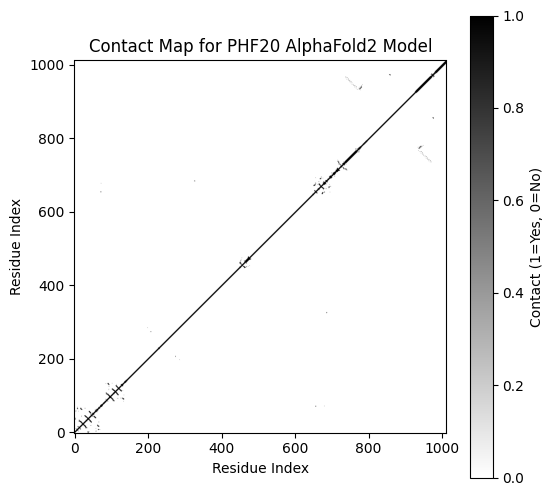

Contact map plot saved as /content/drive/MyDrive/Protein_str/contact_map.png


In [ ]:
def extract_contact_map(pdb_file, threshold=8.0):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("PHF20", pdb_file)
    # Get CA atom coordinates for all standard amino acids
    coords = [residue["CA"].get_coord()
              for model in structure
              for chain in model
              for residue in chain
              if is_aa(residue, standard=True) and "CA" in residue]

    if not coords:
        return None
    coords = np.array(coords)
    # Compute pairwise distances
    dist_matrix = squareform(pdist(coords))
    # Create binary contact map (1 if distance < threshold)
    contact_map = (dist_matrix < threshold).astype(int)
    return contact_map


# Generate the contact map
contact_map = extract_contact_map(pdb_path)

# Create the plot
plt.figure(figsize=(6,6))
plt.imshow(contact_map, cmap="gray_r", origin="lower")
plt.title("Contact Map for PHF20 AlphaFold2 Model")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="Contact (1=Yes, 0=No)")

# Save the plot to Google Drive
save_path = "/content/drive/MyDrive/Protein_str/contact_map.png"
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Contact map plot saved as {save_path}")


In [ ]:
# Load the structure using MDAnalysis
u = mda.Universe(pdb_path)

# Set up and run the hydrogen bond analysis with the correct parameters
hbond_analysis = HBA(u,
                     donors_sel="protein",
                     hydrogens_sel="protein",
                     acceptors_sel="protein",
                     d_h_cutoff=1.2,           # donor-hydrogen distance cutoff
                     d_a_cutoff=3.5,           # donor-acceptor distance cutoff (increased slightly from default)
                     d_h_a_angle_cutoff=150,   # D-H-A angle cutoff
                     update_selections=True)

hbond_analysis.run()

print("Number of hydrogen bonds identified:", len(hbond_analysis.hbonds))
for hb in hbond_analysis.hbonds[:10]:  # print first 10 hydrogen bonds
    print(hb)

/usr/local/lib/python3.11/dist-packages/MDAnalysis/analysis/base.py:542: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[idx] = ts.time


Number of hydrogen bonds identified: 33080
[  0.           1.           0.           6.           3.32215707
 150.01239751]
[  0.           4.           4.           2.           2.05391395
 180.        ]
[  0.           4.           4.           0.           1.47450897
 180.        ]
[  0.           4.           4.         640.           3.44521588
 180.        ]
[  0.           4.           4.           3.           2.04768807
 180.        ]
[  0.           4.           4.           1.           2.08924365
 180.        ]
[  0.          5.          5.          2.          2.9461234 180.       ]
[  0.           5.           5.           0.           2.11372816
 180.        ]
[  0.           5.           5.           3.           2.38627195
 180.        ]
[  0.          5.          5.          1.          2.4882648 180.       ]


/usr/local/lib/python3.11/dist-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:809: DeprecationWarning: The `hbonds` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.hbonds` instead.
  warnings.warn(wmsg, DeprecationWarning)


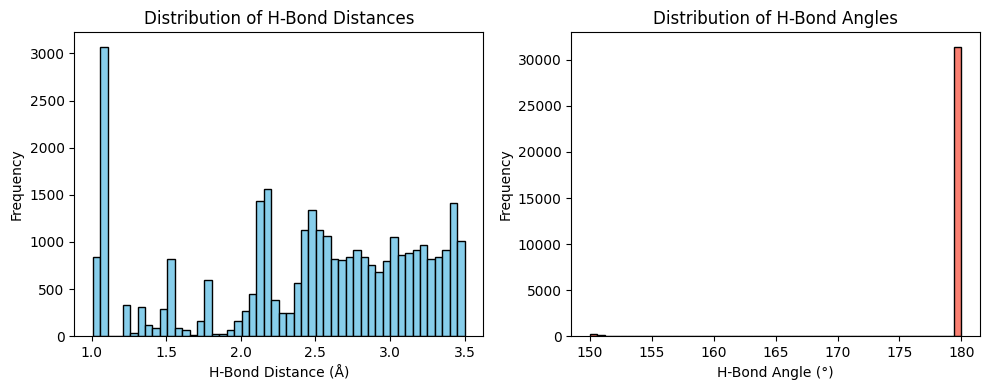

Plots saved to /content/drive/MyDrive/Protein_str/hbond_distribution.png


In [ ]:
# Convert hbonds list to a NumPy array (columns: frame, donor id, hydrogen id, acceptor id, distance, angle)
hbonds = np.array(hbond_analysis.hbonds)  # One use hbond_analysis.results.hbonds if preferred
distances = hbonds[:, 4]
angles = hbonds[:, 5]

# Create a figure with two subplots for distances and angles
plt.figure(figsize=(10, 4))

# Histogram for hydrogen bond distances
plt.subplot(1, 2, 1)
plt.hist(distances, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("H-Bond Distance (Å)")
plt.ylabel("Frequency")
plt.title("Distribution of H-Bond Distances")

# Histogram for hydrogen bond angles
plt.subplot(1, 2, 2)
plt.hist(angles, bins=50, color='salmon', edgecolor='black')
plt.xlabel("H-Bond Angle (°)")
plt.ylabel("Frequency")
plt.title("Distribution of H-Bond Angles")

plt.tight_layout()

# Save the plot to your Google Drive folder
save_path = "/content/drive/MyDrive/Protein_str/hbond_distribution.png"
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Plots saved to {save_path}")
